# **PROJET ITK-VTK**

## Auteurs
### Majeure IMAGE

- David CHEMALY
    - login: david.chemaly
<br /> <br />
- Thuraya SHANBARI
    - login: thuraya.shanbari

# Partie 2
---

## Import des librairies

In [1]:
import itk
itk.Version.GetITKVersion()

'5.3.0'

In [2]:
import vtk
vtk.vtkVersion.GetVTKVersion()

'9.2.6'

In [3]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.7.1'

## Paramètres

In [4]:
image1_path = 'Data/case6_gre1.nrrd'
image2_path = 'Data/case6_gre2.nrrd'

Dimension = 3
PixelTypeF = itk.ctype('float')
ImageTypeF = itk.Image[PixelTypeF, Dimension]

PixelTypeUC = itk.ctype('unsigned char')
ImageTypeUC = itk.Image[PixelTypeUC, Dimension]

## Chargement des données

In [5]:
def read_file(file_path, ImageType):
    readerType = itk.ImageFileReader[ImageType]
    reader = readerType.New()
    reader.SetFileName(file_path)
    reader.Update()
    image = reader.GetOutput()
    return image

In [6]:
image1F = read_file(image1_path, ImageTypeF)
image2F = read_file(image2_path, ImageTypeF)

image1UC = read_file(image1_path, ImageTypeUC)
image2UC = read_file(image2_path, ImageTypeUC)

print("image1F size: " + str(image1F.GetLargestPossibleRegion().GetSize()))
print("image2F size: " + str(image2F.GetLargestPossibleRegion().GetSize()))

print("image1UC size: " + str(image1UC.GetLargestPossibleRegion().GetSize()))
print("image2UC size: " + str(image2UC.GetLargestPossibleRegion().GetSize()))

image1F size: itkSize3 ([256, 256, 176])
image2F size: itkSize3 ([256, 256, 176])
image1UC size: itkSize3 ([256, 256, 176])
image2UC size: itkSize3 ([256, 256, 176])


## Affichage des données

In [7]:
def display_image(image, slice_number):
    plt.imshow(image[slice_number,:,:], cmap='gray')
    plt.show()

## Pipeline

### 1. Segmentation Watershed

In [8]:
def segmentation_watershed(image):

    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    GradientMagnitudeImageFilterType = itk.GradientMagnitudeRecursiveGaussianImageFilter[InternalImageType, InternalImageType]
    gradientMagnitudeImageFilter = GradientMagnitudeImageFilterType.New()
    gradientMagnitudeImageFilter.SetInput(image)
    gradientMagnitudeImageFilter.SetSigma(1.0)

    WatershedFilterType = itk.WatershedImageFilter[InternalImageType]
    watershedFilter = WatershedFilterType.New()

    watershedFilter.SetInput(gradientMagnitudeImageFilter.GetOutput())
    watershedFilter.SetThreshold(0.01)
    watershedFilter.SetLevel(0.2)

    watershedFilter.Update()

    return watershedFilter.GetOutput()

In [9]:
watershed = segmentation_watershed(image1F)
print("watershed size: " + str(watershed.GetLargestPossibleRegion().GetSize()))

watershed size: itkSize3 ([256, 256, 176])


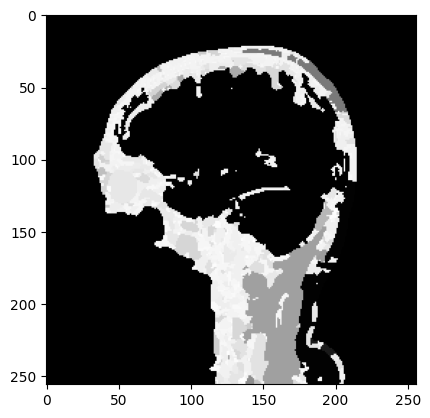

In [10]:
display_image(watershed, 116)

### 2. Segmentation Connected Threshold

In [27]:
def segmentation_connected_threshold(image, seed, lower, upper):

    CurvatureFlowImageFilterType = itk.CurvatureFlowImageFilter[ImageTypeF, ImageTypeF]
    smoother = CurvatureFlowImageFilterType.New()

    ConnectedFilterType = itk.ConnectedThresholdImageFilter[ImageTypeF, ImageTypeF]
    connected_threshold = ConnectedFilterType.New()

    smoother.SetInput(image)
    connected_threshold.SetInput(smoother.GetOutput())

    smoother.SetNumberOfIterations(5)
    smoother.SetTimeStep(0.125)

    connected_threshold.SetLower(lower)
    connected_threshold.SetUpper(upper)
    connected_threshold.SetReplaceValue(255)

    connected_threshold.AddSeed(seed)

    connected_threshold.Update()

    return connected_threshold.GetOutput()

In [30]:
con_thresh = segmentation_connected_threshold(image1F, [50, 50, 50], 0, 255)
print("con_thresh size: " + str(con_thresh.GetLargestPossibleRegion().GetSize()))

con_thresh size: itkSize3 ([256, 256, 176])


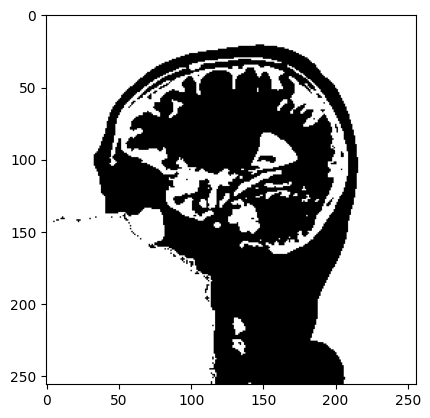

In [31]:
display_image(con_thresh, 116)

### 3. Segmentation Otsu Threshold

In [14]:
def segmentation_otsu(image):
    InputPixelType = itk.ctype('unsigned char')
    OutputPixelType = itk.ctype('unsigned char')
    InputImageType = itk.Image[InputPixelType, Dimension]
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    FilterType = itk.OtsuThresholdImageFilter[InputImageType, OutputImageType]
    otsuFilter = FilterType.New()

    otsuFilter.SetInput(image)
    otsuFilter.SetInsideValue(0)
    otsuFilter.SetOutsideValue(255)

    try:
        otsuFilter.Update()
    except Exception as e:
        print(e)
        return None
    
    return otsuFilter.GetOutput()

In [15]:
otsu = segmentation_otsu(image1UC)
print("otsu size: " + str(otsu.GetLargestPossibleRegion().GetSize()))

otsu size: itkSize3 ([256, 256, 176])


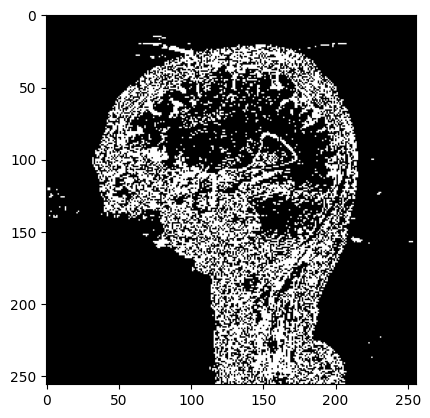

In [16]:
display_image(otsu, 116)

### 4. Segmentation Neighbourhood Connected

In [17]:
def segmentation_neighborhood_connected(image, seed, lower, upper):

    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    CurvatureFlowImageFilterType = itk.CurvatureFlowImageFilter[InternalImageType, InternalImageType]
    smoothing = CurvatureFlowImageFilterType.New()

    NeighborhoodConnectedFilterType = itk.NeighborhoodConnectedImageFilter[InternalImageType, InternalImageType]
    neighborhoodConnected = NeighborhoodConnectedFilterType.New()

    smoothing.SetInput(image)
    neighborhoodConnected.SetInput(smoothing.GetOutput())
    
    smoothing.SetNumberOfIterations(5)
    smoothing.SetTimeStep(0.125)

    neighborhoodConnected.SetLower(lower)
    neighborhoodConnected.SetUpper(upper)

    radius = itk.Size[Dimension]()
    radius.Fill(2)
    neighborhoodConnected.SetRadius(radius)

    neighborhoodConnected.SetSeed(seed)
    neighborhoodConnected.SetReplaceValue(255)

    try:
        neighborhoodConnected.Update()
    except Exception as e:
        print(e)
        return None
    
    return neighborhoodConnected.GetOutput()

In [18]:
nei_con = segmentation_neighborhood_connected(image1F, [50, 50, 50], 0, 255)
print("nei_con size: " + str(nei_con.GetLargestPossibleRegion().GetSize()))

nei_con size: itkSize3 ([256, 256, 176])


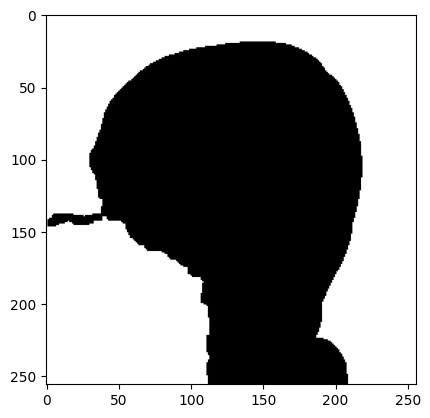

In [19]:
display_image(nei_con, 116)

### 5. Segmentation Isolated Connected

In [20]:
def segmentation_isolated_connected(image):
    
    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    CurvatureFlowImageFilterType = itk.CurvatureFlowImageFilter[InternalImageType, InternalImageType]
    smoothing = CurvatureFlowImageFilterType.New()

    IsolatedConnectedFilterType = itk.IsolatedConnectedImageFilter[InternalImageType, InternalImageType]
    isolatedConnected = IsolatedConnectedFilterType.New()

    smoothing.SetInput(image)
    isolatedConnected.SetInput(smoothing.GetOutput())

    isolatedConnected.SetLower(0)
    isolatedConnected.AddSeed1([50, 50, 50])
    isolatedConnected.AddSeed2([100, 100, 100])
    isolatedConnected.SetReplaceValue(255)

    try:
        isolatedConnected.Update()
    except Exception as e:
        print(e)
        return None
    
    return isolatedConnected.GetOutput()

In [21]:
iso_con = segmentation_isolated_connected(image1F)
print("iso_con size: " + str(iso_con.GetLargestPossibleRegion().GetSize()))

iso_con size: itkSize3 ([256, 256, 176])


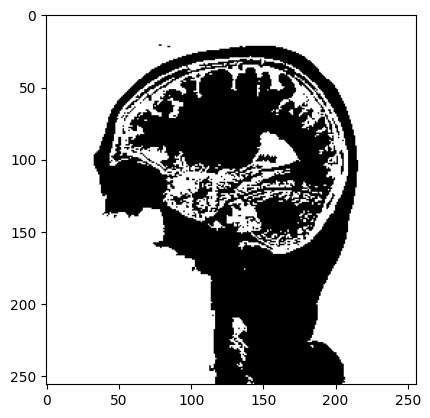

In [22]:
display_image(iso_con, 116)

---